In [1]:
# Przykład ustawienia środowiska z określoną datą i strefą czasową
from rocketpy import Environment

env = Environment(
    date=(2025, 12, 18, 12),  # rok, miesiąc, dzień, godzina
    timezone="Europe/Warsaw"
)

In [2]:
env.set_location(latitude=35.35, longitude=-117.81)

In [3]:
env.set_elevation("Open-Elevation")

Fetching elevation from open-elevation.com for lat=35.35, lon=-117.81...
Elevation received: 621.0 m


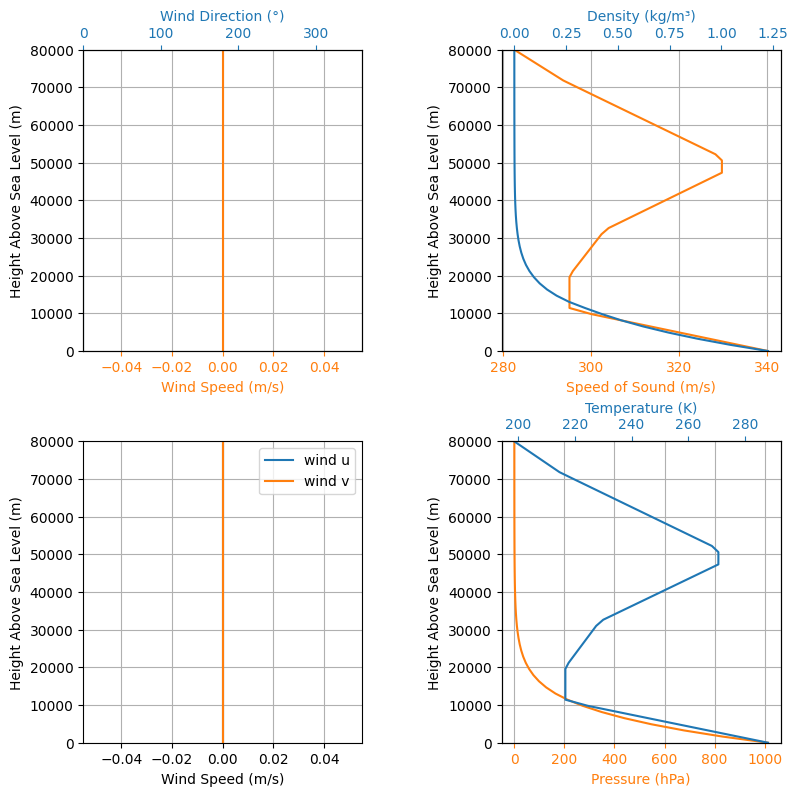

In [4]:
env.plots.atmospheric_model()

In [37]:
from math import exp
from rocketpy import Fluid, LiquidMotor, CylindricalTank, MassFlowRateBasedTank, Rocket, Flight

In [30]:
# 1. DEFINICJA PŁYNÓW (WARUNKI: 60 BAR, ~27.5°C)
# N2O w 60 barach jest blisko punktu krytycznego - jest znacznie rzadszy niż woda!
# Gęstość cieczy spada do ok. 710 kg/m3.
# Gęstość gazu (pary nasyconej) jest bardzo wysoka - ok. 185 kg/m3.
oxidizer_liq = Fluid(name="N2O_l", density=710)
oxidizer_gas = Fluid(name="N2O_g", density=185)

# Etanol jest cieczą mało ściśliwą, spadek gęstości wynika głównie z temperatury (27.5C).
fuel_liq = Fluid(name="ethanol_l", density=782)
# Gaz w zbiorniku paliwa (jeśli są pęcherzyki) to opary etanolu,
# ale w zbiorniku tłokowym ich masa jest pomijalna.
fuel_gas = Fluid(name="ethanol_g", density=1.6)

# 2. GEOMETRIA (Dopasowana do Twoich wymiarów: r=9.3cm)
# Musisz stworzyć dwie osobne geometrie, bo mają różne długości (90cm i 50cm).
ox_tank_shape = CylindricalTank(radius = 0.093, height = 1.2, spherical_caps = True)
fuel_tank_shape = CylindricalTank(radius = 0.093, height = 0.5, spherical_caps = True)

# 3. ZBIORNIKI (Masy wyliczone dla wsadu 25.5 kg)

oxidizer_tank = MassFlowRateBasedTank(
    name="oxidizer tank",
    geometry=ox_tank_shape,
    flux_time=11.2,
    initial_liquid_mass=19.2,       # Wyliczona masa N2O
    initial_gas_mass=0.1,           # Niewielka ilość pary nad cieczą
    liquid_mass_flow_rate_in=0,
    # Zaktualizowałem licznik w lambda, aby startował od realnej masy
    liquid_mass_flow_rate_out=lambda t: 1.7142857,
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=0,
    liquid=oxidizer_liq,
    gas=oxidizer_gas,
)

fuel_tank = MassFlowRateBasedTank(
    name="fuel tank",
    geometry=fuel_tank_shape,
    flux_time=11.2,
    initial_liquid_mass=6.3,        # Wyliczona masa Etanolu
    initial_gas_mass=0.001,         # W tłokowym zbiorniku paliwa gazu powinno być 0
    liquid_mass_flow_rate_in=0,
    # Zaktualizowałem licznik w lambda
    liquid_mass_flow_rate_out=0.5624,
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=0,       # Gaz nie wypływa z paliwa w układzie tłokowym
    liquid=fuel_liq,
    gas=fuel_gas,
)

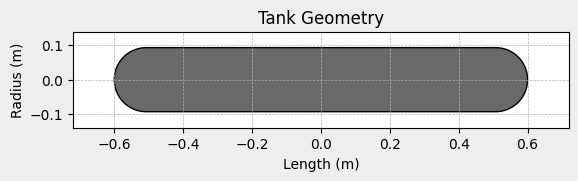

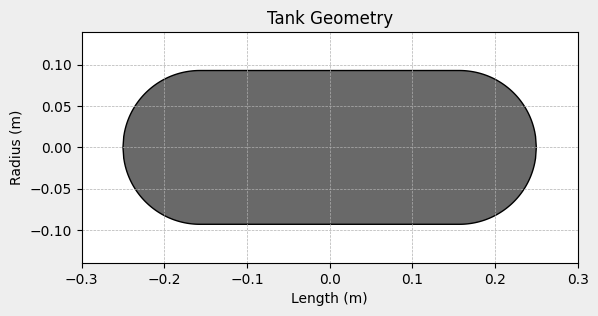

In [31]:
# Draw the tank
oxidizer_tank.draw()
fuel_tank.draw()


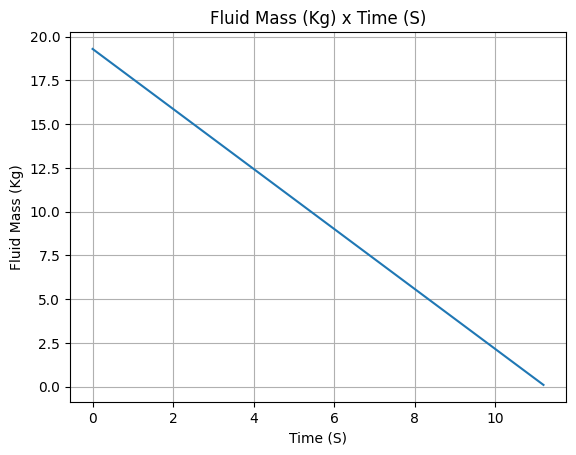

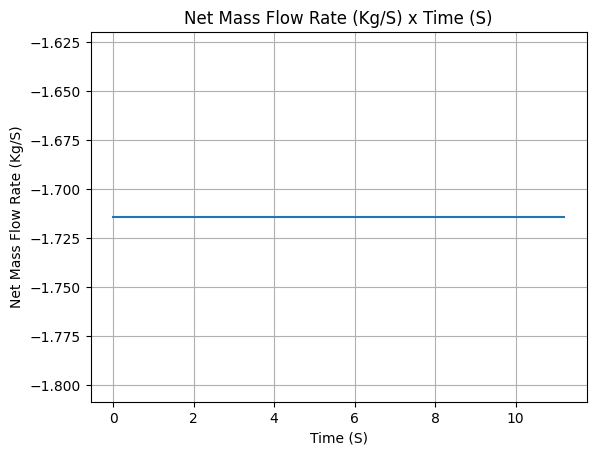

In [32]:
# Evolution of the Propellant Mass and the Mass flow rate
oxidizer_tank.fluid_mass.plot()
oxidizer_tank.net_mass_flow_rate.plot()

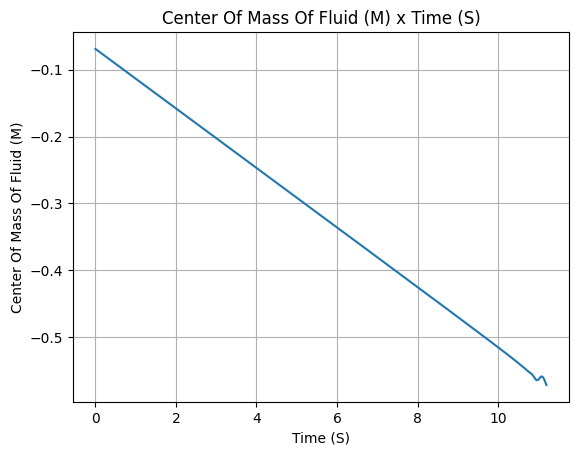

In [33]:
# Evolution of the Propellant center of mass position
oxidizer_tank.center_of_mass.plot()

In [34]:
example_liquid = LiquidMotor(
    thrust_source="C:\\Users\\krikb\\Desktop\\simulations\\data\\AGH-SS_Z4000-10sBurn-optimal.eng",
    dry_mass=2.7,
    dry_inertia=(0.0203499, 0.0203499, 0.003375000000000001),
    nozzle_radius=0.075,
    center_of_dry_mass_position=1.75,
    nozzle_position=0,
    burn_time=14.4,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)
example_liquid.add_tank(tank=oxidizer_tank, position=1.0)
example_liquid.add_tank(tank=fuel_tank, position=2.5)

Nozzle Details
Nozzle Radius: 0.075 m

Motor Details
Total Burning Time: 14.4 s
Total Propellant Mass: 25.601 kg
Structural Mass Ratio: 0.095
Average Propellant Exhaust Velocity: 846.718 m/s
Average Thrust: 2240.935 N
Maximum Thrust: 4575.401 N at 1.089 s after ignition.
Total Impulse: 32269.462 Ns



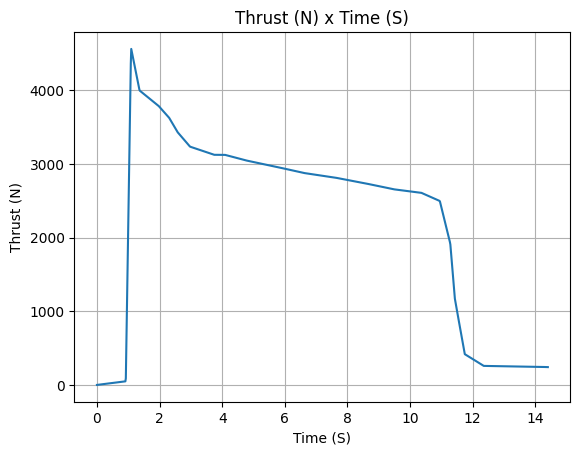

In [35]:
example_liquid.info()

Nozzle Details
Nozzle Radius: 0.075 m

Motor Details
Total Burning Time: 14.4 s
Total Propellant Mass: 25.601 kg
Structural Mass Ratio: 0.095
Average Propellant Exhaust Velocity: 846.718 m/s
Average Thrust: 2240.935 N
Maximum Thrust: 4575.401 N at 1.089 s after ignition.
Total Impulse: 32269.462 Ns



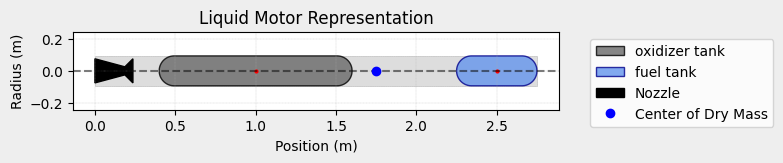

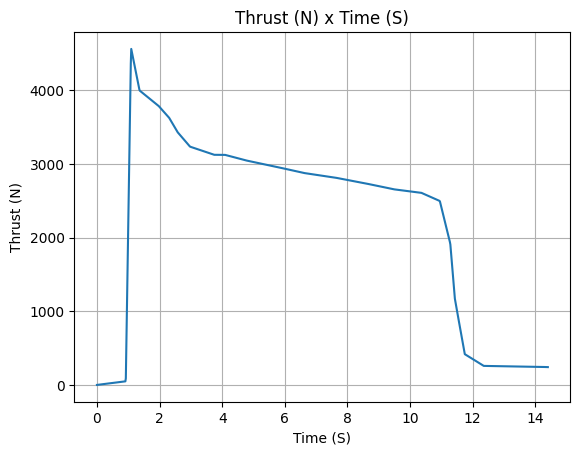

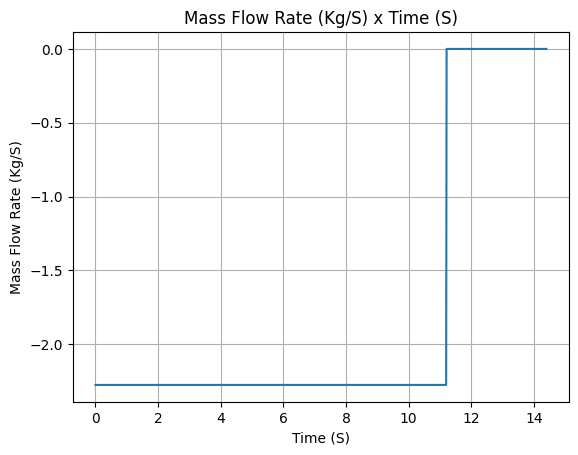

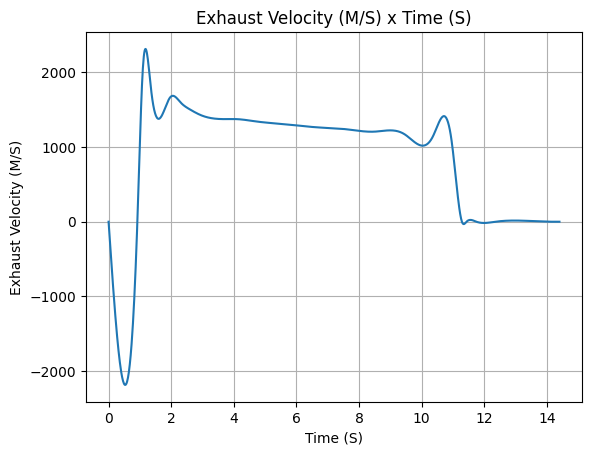

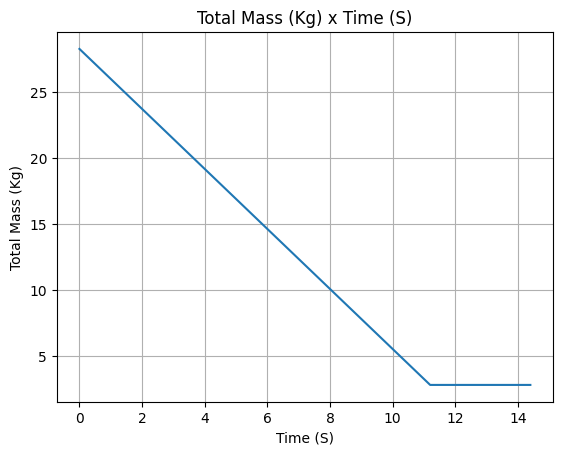

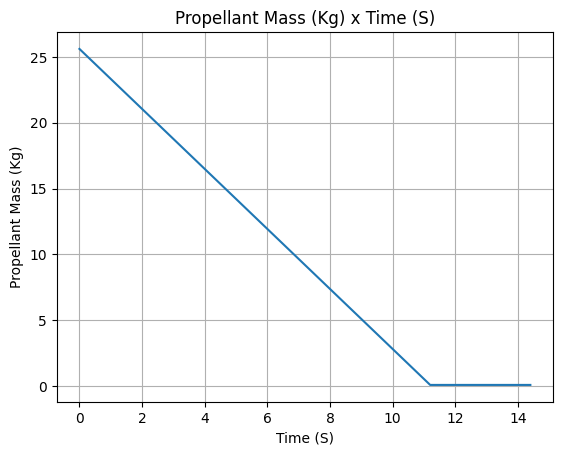

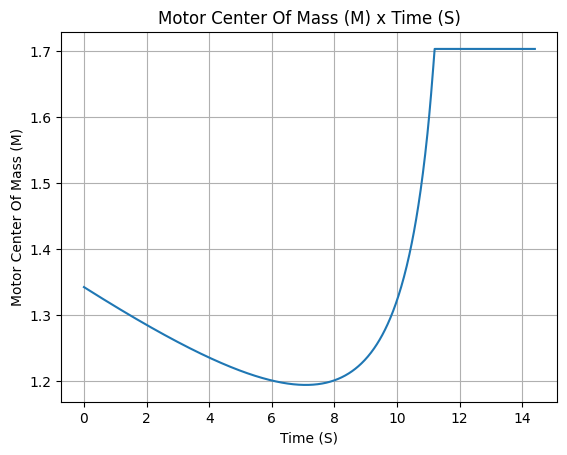

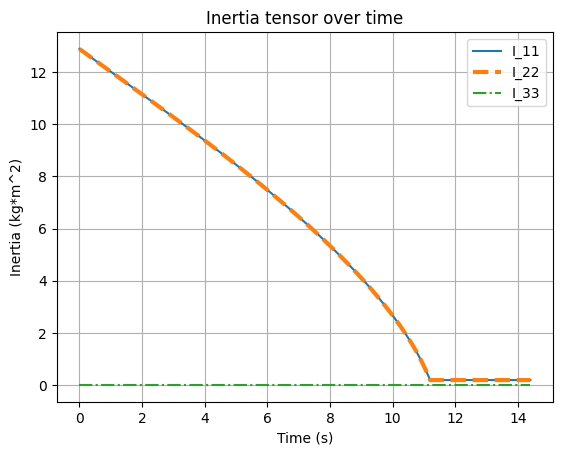

In [36]:
example_liquid.all_info()

In [42]:
TRB = Rocket(
    radius=0.2,
    mass=58.367,
    inertia=(6.321, 6.321, 0.034),
    power_off_drag="C:\\Users\\krikb\\Desktop\\simulations\\data\\powerOffDragCurve.csv",
    power_on_drag="C:\\Users\\krikb\\Desktop\\simulations\\data\\powerOnDragCurve.csv",
    center_of_mass_without_motor=0,
    coordinate_system_orientation="tail_to_nose",
)

In [53]:
TRB.add_motor(example_liquid, position=-1)

Only one motor per rocket is currently supported. Overwriting previous motor.


In [44]:

rail_buttons = TRB.set_rail_buttons(
    upper_button_position=0.0818,
    lower_button_position=-0.6182,
    angular_position=45,
)

In [55]:
nose_cone = TRB.add_nose(
    length=0.7, kind="von karman", position=4
)

fin_set = TRB.add_trapezoidal_fins(
    n=4,
    root_chord=0.120,
    tip_chord=0.060,
    span=0.110,
    position=-1.04956,
    cant_angle=0.5,
)

tail = TRB.add_tail(
    top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
)

In [47]:
main = TRB.add_parachute(
    name="main",
    cd_s=10.0,
    trigger=800,      # ejection altitude in meters
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
    radius=1.5,
    height=1.5,
    porosity=0.0432,
)

drogue = TRB.add_parachute(
    name="drogue",
    cd_s=1.0,
    trigger="apogee",  # ejection at apogee
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
    radius=1.5,
    height=1.5,
    porosity=0.0432,
)

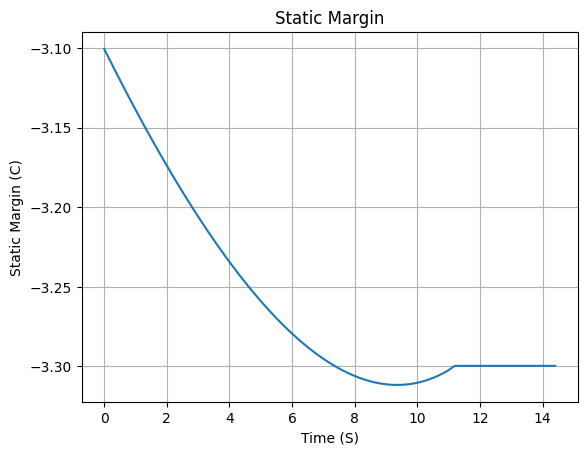

In [57]:
TRB.plots.static_margin()

In [58]:
test_flight = Flight(
    rocket=TRB, environment=env, rail_length=5.2, inclination=85, heading=0
    )

KeyboardInterrupt: 

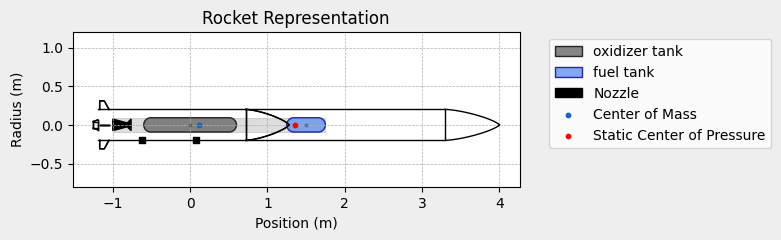

In [56]:
TRB.draw()